In [59]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential, layers
from sklearn.utils import class_weight

In [60]:
train = pd.read_csv('/kaggle/input/model-datatest-skincancer/train_data.csv')
val = pd.read_csv('/kaggle/input/model-datatest-skincancer/val_data.csv')
test = pd.read_csv('/kaggle/input/model-datatest-skincancer/test_data_remove_unk.csv')

In [62]:
class CFG:
    EPOCHS = 20
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    WIDTH = 224
    HEIGHT = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [63]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['diagnosis']),
    y=train['diagnosis']
)
class_weights_dict = dict(enumerate(class_weights))


In [64]:
def hair_remove(image):
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1, (17, 17))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
    return final_image

In [65]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    image_uint8 = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image_uint8 = tf.numpy_function(hair_remove, [image_uint8], tf.uint8)
    image = tf.cast(image, tf.float32) / 255.
    return image

In [66]:
# augmentation_layer = Sequential([
#     layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
#     layers.RandomRotation(factor=0.1, seed=CFG.TF_SEED),  
#     layers.RandomContrast(factor=0.2, seed=CFG.TF_SEED),  
#     layers.RandomBrightness(factor=0.2, seed=CFG.TF_SEED),  
#     layers.GaussianNoise(stddev=0.1),  
# ], name='augmentation_layer')

augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

In [67]:
def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    image_paths = df.path_jpg
    image_labels = df.diagnosis
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y))
    else:
        ds = ds.map(lambda x, y: (load_function(x), y))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    
    ds = ds.batch(batch_size)
    
    if cache is not None:
        ds = ds.cache(cache)
    
    if prefetch:
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return ds

In [68]:
train_ds = create_pipeline(train, load_image, augment=True, batch_size=CFG.BATCH_SIZE, shuffle=True, prefetch=True)
val_ds = create_pipeline(val, load_image, batch_size=CFG.BATCH_SIZE, shuffle=False, prefetch=False)

In [69]:
def EfficientNetB0_model(input_shape=CFG.IMAGE_SIZE, num_classes=8):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, kernel_regularizer='l2', activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [70]:
ENB0_model = EfficientNetB0_model()

In [71]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, tf_valid_data=None, shuffling=False, class_weight=None):
    model_history = model.fit(tf_train_data,
                              epochs=num_epochs,
                              validation_data=tf_valid_data if tf_valid_data else None,
                              callbacks=callbacks_list,
                              shuffle=shuffling,
                              class_weight=class_weight)
    return model_history

In [72]:
optimizer = Adam(3e-5)
ENB0_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [73]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint('best_model_enb0.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
callback_list = [model_chkpt, lr_reduce, early_stop]

In [74]:
print(f'Training {ENB0_model.name}.')
print(f'Train on {len(train)} samples, validate on {len(val)} samples.')
print('----------------------------------')

ENB0_history = train_model(
    ENB0_model, CFG.EPOCHS, callback_list,
    train_ds, val_ds,
    shuffling=False, class_weight=class_weights_dict
)

Training functional_7.
Train on 20264 samples, validate on 5067 samples.
----------------------------------
Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.1701 - loss: 4.2837
Epoch 1: val_accuracy improved from -inf to 0.21808, saving model to best_model_enb0.keras
634/634 ━━━━━━━━━━━━━━━━━━━━ 577s 792ms/step - accuracy: 0.1702 - loss: 4.2836 - val_accuracy: 0.2181 - val_loss: 4.1194 - learning_rate: 3.0000e-05
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.4147 - loss: 3.6520
Epoch 2: val_accuracy improved from 0.21808 to 0.56049, saving model to best_model_enb0.keras
634/634 ━━━━━━━━━━━━━━━━━━━━ 489s 738ms/step - accuracy: 0.4148 - loss: 3.6519 - val_accuracy: 0.5605 - val_loss: 3.2440 - learning_rate: 3.0000e-05
Epoch 3/20
633/634 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.4987 - loss: 3.2544
Epoch 3: val_accuracy improved from 0.56049 to 0.60114, saving model to best_model_enb0.keras
634/634 ━━━━━━━━━━━━━━━━━━━━ 472s 717ms/step - accu

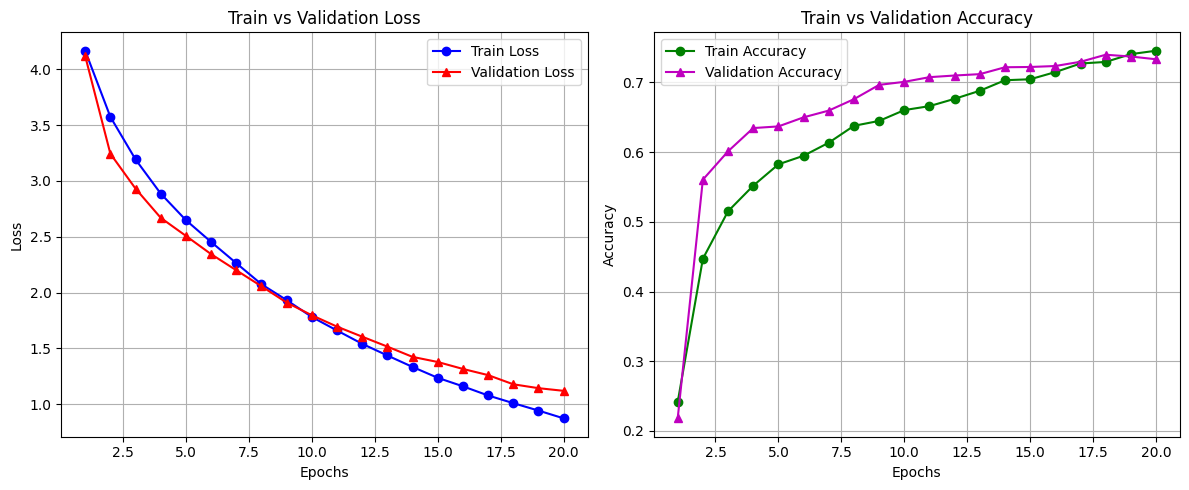

In [76]:
import matplotlib.pyplot as plt
train_loss = ENB0_history.history['loss']
val_loss = ENB0_history.history['val_loss']
train_acc = ENB0_history.history['accuracy']
val_acc = ENB0_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1) 


plt.figure(figsize=(12, 5))

#  Loss
plt.subplot(1, 2, 1)  
plt.plot(epochs, train_loss, 'bo-', label='Train Loss')  
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

#  Accuracy
plt.subplot(1, 2, 2)  
plt.plot(epochs, train_acc, 'go-', label='Train Accuracy')  
plt.plot(epochs, val_acc, 'm^-', label='Validation Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

# TEST

In [77]:
def create_pipeline_test(df, load_image, batch_size=32, prefetch=True):
    image_paths = df["path_jpg"].values
    dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(load_image)

    dataset = dataset.batch(batch_size)

    if prefetch:
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [78]:
test_ds = create_pipeline_test(test, load_image, batch_size=CFG.BATCH_SIZE, prefetch=True)

# Eval

In [90]:
best_model = tf.keras.models.load_model("/kaggle/working/best_model_enb0.keras")

In [91]:
test_preds = best_model.predict(test_ds)

194/194 ━━━━━━━━━━━━━━━━━━━━ 88s 434ms/step


In [92]:
test_labels_pred = np.argmax(test_preds, axis=1)

In [93]:
test['prediction'] = test_labels_pred

In [94]:
test_data = test[['image', 'prediction']]
test_data

,image,prediction
0,ISIC_0034321,4
1,ISIC_0034322,4
2,ISIC_0034323,4
3,ISIC_0034324,4
4,ISIC_0034325,4
...,...,...
6186,ISIC_0073226,4
6187,ISIC_0073234,4
6188,ISIC_0073236,4
6189,ISIC_0073243,4


In [84]:
class_mapping = {0: 'AK', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'SCC', 7: 'VASC'}
test_data['diagnosis'] = test_data['prediction'].map(class_mapping)
test_data.head()

<ipython-input-84-dead8306c724>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['diagnosis'] = test_data['prediction'].map(class_mapping)


,image,prediction,diagnosis
0,ISIC_0034321,4,MEL
1,ISIC_0034322,4,MEL
2,ISIC_0034323,4,MEL
3,ISIC_0034324,4,MEL
4,ISIC_0034325,4,MEL


In [88]:
test_gt = pd.read_csv('/kaggle/input/model-datatest-skincancer/test_gt_remove_unk.csv')
test_gt.head()

,image,diagnosis
0,ISIC_0034321,NV
1,ISIC_0034322,NV
2,ISIC_0034323,BCC
3,ISIC_0034324,NV
4,ISIC_0034325,NV


In [89]:
accuracy = (test_data['diagnosis'] == test_gt['diagnosis']).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.2027
